# Detection of COVID-19 in X-Ray Images (COVID-19 vs. Normal)

##### Notebook settings

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Prerequisites

##### Import libraries

In [ ]:
import os, random
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental.preprocessing import Resizing, Rescaling, RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from keras.layers import Layer, InputLayer, Conv2D, Activation, Add, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, ZeroPadding2D, Flatten

##### Download dataset

###### *COVID-19 Radiography Database*  
[Kaggle](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)
[Paper 1](https://ieeexplore.ieee.org/document/9144185)
[Paper 2](https://doi.org/10.1016/j.compbiomed.2021.104319)

In [ ]:
if not os.path.exists('COVID-19_Radiography_Dataset'):
    !gdown https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
    !unzip -q COVID-19_Radiography_Database.zip
    !rm COVID-19_Radiography_Database.zip

Downloading...
From: https://drive.google.com/uc?id=1ZMgUQkwNqvMrZ8QaQmSbiDqXOWAewwou
To: /content/COVID-19_Radiography_Database.zip
780MB [00:08, 94.8MB/s]


##### Define constants

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Data parameters
SPLIT = 0.15
IMBALANCE_RATIO = 1.5

# Model parameters
BATCH_SIZE = 32
IMG_SIZE = [256, 256] # dataset image size is 299x299
EPOCHS = 20

# Set fixed random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
random_state = 42

## Data


### Create dataset

In [ ]:
savepath = 'data'

## dataset from https://www.kaggle.com/tawsifurrahman/covid19-radiography-database

# path to normal 
normal_imgpath = 'COVID-19_Radiography_Dataset/Normal'
normal_csvpath = 'COVID-19_Radiography_Dataset/Normal.metadata.xlsx'

# path to covid-19 
covid_imgpath = 'COVID-19_Radiography_Dataset/COVID'
covid_csvpath = 'COVID-19_Radiography_Dataset/COVID.metadata.xlsx'

# path to opacity 
opacity_imgpath = 'COVID-19_Radiography_Dataset/Lung_Opacity'
opacity_csvpath = 'COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx'

# path to pneumonia 
pneumonia_imgpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia'
pneumonia_csvpath = 'COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx'

In [ ]:
# stats
normal_cnt = len([name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))])
covid_cnt = len([name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))])
pneumonia_cnt = len([name for name in os.listdir(opacity_imgpath) if os.path.isfile(os.path.join(opacity_imgpath, name))]) + len([name for name in os.listdir(pneumonia_imgpath) if os.path.isfile(os.path.join(pneumonia_imgpath, name))])

class_count = {'normal': normal_cnt, 'COVID-19': covid_cnt, 'pneumonia': pneumonia_cnt}
print('Class count: ', class_count)
print('Total images: ', normal_cnt + covid_cnt + pneumonia_cnt)

Class count:  {'normal': 10192, 'COVID-19': 3616, 'pneumonia': 7357}
Total images:  21165


### Load dataset

###### Retrieve filenames (paths) and labels

In [ ]:
def get_data(paths, label_encoding):
    normal_imgpath, covid_imgpath = paths
    filenames = []
    y_labels = []

    # COVID-19
    covid_images = [covid_imgpath + '/' + name for name in os.listdir(covid_imgpath) if os.path.isfile(os.path.join(covid_imgpath, name))]
    random.shuffle(covid_images)
    covid_images = covid_images[:int(len(covid_images))]
    filenames.extend(covid_images)
    y_labels.extend([label_encoding.index('COVID-19') for img in covid_images])

    # normal
    normal_images = [normal_imgpath + '/' + name for name in os.listdir(normal_imgpath) if os.path.isfile(os.path.join(normal_imgpath, name))]
    random.shuffle(normal_images)
    normal_images = normal_images[:int(IMBALANCE_RATIO*len(covid_images))]
    filenames.extend(normal_images)
    y_labels.extend([label_encoding.index('normal') for img in normal_images])

    return np.array(filenames), np.array(y_labels)

In [ ]:
datapaths = ['COVID-19_Radiography_Dataset/Normal', 'COVID-19_Radiography_Dataset/COVID']
label_encoding = ['normal', 'COVID-19'] # normal = 0, COVID-19 = 1

files, labels = get_data(datapaths, label_encoding)

###### Create train-test split

In [ ]:
# create train-test split
x_train, x_test, y_train, y_test = train_test_split(files, labels, test_size=SPLIT, random_state=random_state)

In [ ]:
def get_distribution(y):
    return {'normal': np.count_nonzero(y == 0),
            'COVID-19': np.count_nonzero(y == 1)}

In [ ]:
TRAIN_IMG_COUNT = len(y_train)
TEST_IMG_COUNT = len(y_test)
print(
    'Train: ' + str(TRAIN_IMG_COUNT) + ',',
    'Test: ' + str(TEST_IMG_COUNT),
)

Train: 7684, Test: 1356


In [ ]:
TRAIN_DISTRIBUTION = get_distribution(y_train)
TEST_DISTRIBUTION = get_distribution(y_test)
print('train set: ', TRAIN_DISTRIBUTION)
print('test set:  ', TEST_DISTRIBUTION)

train set:  {'normal': 4607, 'COVID-19': 3077}
test set:   {'normal': 817, 'COVID-19': 539}


###### Create tensors

In [ ]:
# build tensorflow dataset
train_files = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_files = tf.data.Dataset.from_tensor_slices((x_test, y_test))

###### Image retrieval

In [ ]:
def get_img(x, y):
    path = x
    label = y
    # load the raw data from the file as a string
    img = tf.io.read_file(path)
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_image(img, channels=3, expand_animations = False)
    return img, label

In [ ]:
train_ds = train_files.map(get_img, num_parallel_calls=AUTOTUNE)
test_ds = test_files.map(get_img, num_parallel_calls=AUTOTUNE)

### Prepare for training

###### Define preprocessing and data augmentation

In [ ]:
preprocessing = tf.keras.Sequential([
  Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  Rescaling(scale=1./255)
])

In [ ]:
# implemented as keras layers below but kept for overview
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=(0.85, 1.15),
        brightness_range=(0.9, 1.1),
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        fill_mode='constant',
        cval=0.,)

In [ ]:
class RandomBrightness(Layer):
  def __init__(self, factor=0.1, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return tf.image.random_brightness(x, max_delta=self.factor)

In [ ]:
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='constant'),
  RandomTranslation(0.1, 0.1, fill_mode='constant'),
  RandomZoom(0.15, fill_mode='constant'),
  RandomBrightness(0.1),
])

###### Prepare datasets for use

In [ ]:
def prepare_dataset(ds, cache=True, pre=False, shuffle=False, repeat=False, batch=False, augment=False, shuffle_buffer_size=1000):
    # give string to cache preprocessing for datasets outside of memory
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    # Resize and rescale images
    if pre:
        ds = ds.map(lambda x, y: (preprocessing(x), y),
                    num_parallel_calls=AUTOTUNE)
    # shuffle dataset
    if shuffle:
        ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # repeat set forever or once
    if repeat:
        ds = ds.repeat()
    else:
        ds = ds.repeat(1)
    # batch dataset
    if batch:
        if str(batch) == '1':
            ds = ds.batch(batch).prefetch(buffer_size=AUTOTUNE)
        else:
            ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
    # use data augmentation
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds

In [ ]:
# batch datasets
train_batched = prepare_dataset(train_ds,
                                pre=True,
                                shuffle=True,
                                repeat=True,
                                batch=True,
                                augment=True,
                                cache='./data.tfcache')
test_batched = prepare_dataset(test_ds,
                               pre=True,
                               shuffle=False,
                               repeat=False,
                               batch=True,
                               augment=False)

In [ ]:
# seperate train labels and images for attacks
train_unbatched= prepare_dataset(train_ds,
                                 pre=True,
                                 shuffle=True,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_train_attack = prepare_dataset(train_unbatched,
                                 pre=False,
                                 shuffle=False,
                                 repeat=False,
                                 batch=1, # TODO batching needed?
                                 augment=False)
y_train_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(train_unbatched):
    y_train_attack.append(y)

# seperate test labels and images for attacks
test_unbatched = prepare_dataset(test_ds,
                                 pre=True,
                                 shuffle=False,
                                 repeat=False,
                                 batch=False,
                                 augment=False,
                                 cache=False)
x_test_attack = prepare_dataset(test_unbatched,
                                pre=False,
                                shuffle=False,
                                repeat=False,
                                batch=1, # TODO batching needed?
                                augment=False)
x_test_attack2 = []
y_test_attack = []
for x, y in tf.data.Dataset.as_numpy_iterator(test_unbatched):
    x_test_attack2.append(x)
    y_test_attack.append(y)

### Visualization

###### Distribution of labels in the sets

In [ ]:
def plot_distributions(distributions):
    sns.set_style('darkgrid')
    n_plots = len(distributions)
    fig, ax = plt.subplots(1,n_plots, figsize=(15,5))
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    for i, x in enumerate(distributions.items()):
        name = x[0]
        dis = x[1]
        keys = list(dis.keys())
        values = list(dis.values())
        sns.barplot(x=keys, y=values, ax=ax[i]).set_title(name)
    fig.show()

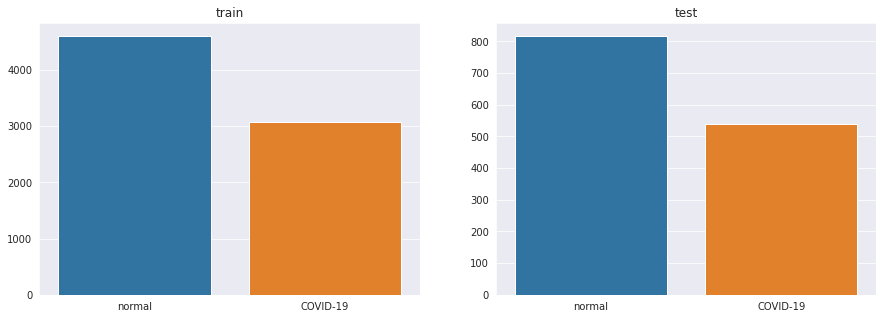

In [ ]:
plot_distributions({'train': TRAIN_DISTRIBUTION, 'test': TEST_DISTRIBUTION})

###### Images from a training batch

In [ ]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    img_num = 9 if BATCH_SIZE > 9 else BATCH_SIZE
    for n in range(img_num):
        ax = plt.subplot(np.log(img_num) / np.log(2), np.log(img_num) / np.log(2), n+1)
        plt.imshow(image_batch[n])
        if label_batch[n] == 0:
            plt.title("NORMAL")
        elif label_batch[n] == 1:
            plt.title("COVID-19")
        plt.axis("off")

In [ ]:
image_batch, label_batch = next(iter(train_batched))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


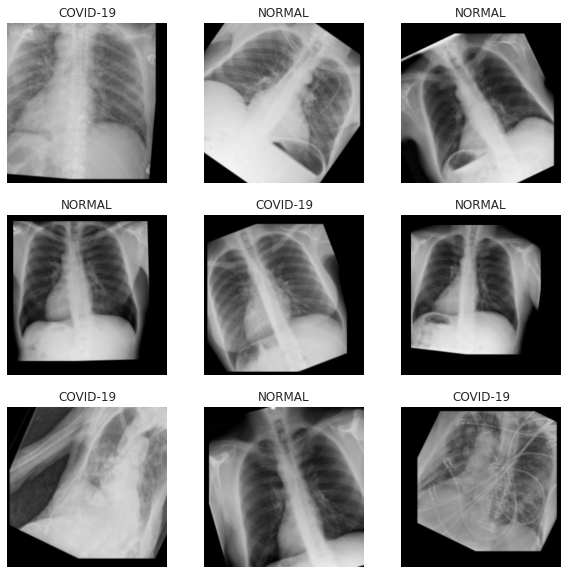

In [ ]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Tuning

### Data Imbalance Correction

###### Define class weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
class_weight_dict = dict(enumerate(class_weights))

weight_iter = iter(class_weight_dict.values())

print('Weight for normal: \t{:.2f}'.format(next(weight_iter)))
print('Weight for COVID-19: \t{:.2f}'.format(next(weight_iter)))

Weight for normal: 	0.83
Weight for COVID-19: 	1.25


### Learning rate decay

In [ ]:
learning_rate_decay = ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1, min_lr=1e-6)

## DP-Net - CNN Archecture for DP-SGD
Based on [Paper 1](https://arxiv.org/abs/2007.14191)
\([Paper 2](https://openreview.net/forum?id=rJg851rYwH)\)
[Paper BN](https://arxiv.org/pdf/2006.10919.pdf)

### Model definition

In [ ]:
def dpnet_builder():
    # create DP-Net
    dpnet = Sequential([
        InputLayer(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
        Conv2D(filters=16, kernel_size=(8,8), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(filters=32, kernel_size=(4,4), strides=2, padding='valid', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(units=32, activation='relu'),
        BatchNormalization(),
        Dense(units=1, activation='sigmoid'),
    ])
    return dpnet

In [ ]:
dpnet = dpnet_builder()

METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

dpnet.compile(
    optimizer=Adam(lr=1e-3), # default: 1e-3
    loss='binary_crossentropy',
    metrics=METRICS
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
dpnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      3088      
_________________________________________________________________
batch_normalization (BatchNo (None, 125, 125, 16)      64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        8224      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0

### Training

In [ ]:
history_dpnet = dpnet.fit(
    train_batched,
    steps_per_epoch=TRAIN_IMG_COUNT//BATCH_SIZE,
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    callbacks=[learning_rate_decay],
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2
240/240 [==============================] - 138s 468ms/step - loss: 0.6636 - accuracy: 0.6618 - precision: 0.5633 - recall: 0.6911
Epoch 2/2
240/240 [==============================] - 99s 411ms/step - loss: 0.5430 - accuracy: 0.7158 - precision: 0.6242 - recall: 0.7501


### Evaluation

###### Visualize performance

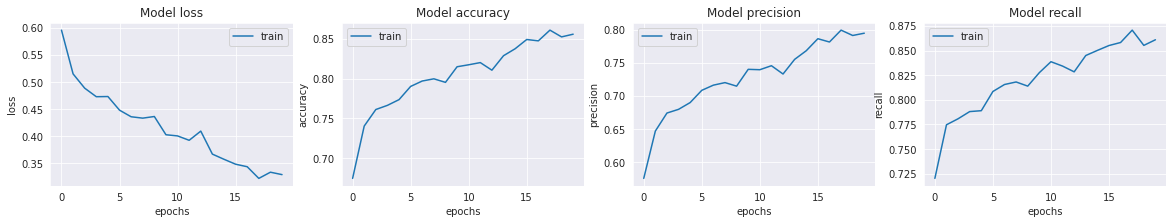

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['loss', 'accuracy', 'precision', 'recall']):
    ax[i].plot(history_dpnet.history[met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train'])

###### Predict on test set

In [ ]:
loss, acc, prec, rec = dpnet.evaluate(test_batched)
print("Loss of the model is - " , loss)
print("Accuracy of the model is - " , acc*100 , "%")
print("Precision of the model is - " , prec)
print("Recall of the model is - " , rec)

43/43 [==============================] - 4s 75ms/step - loss: 0.2356 - accuracy: 0.9012 - precision: 0.8729 - recall: 0.8794
Loss of the model is -  0.23561064898967743
Accuracy of the model is -  90.11799693107605 %
Precision of the model is -  0.8729282021522522
Recall of the model is -  0.8794063329696655


## Privacy

### Compute epsilon

In [ ]:
# delta rule of thumb: set to less than the inverse of the training data size
DELTA = 1e-4

In [ ]:
# computes epsilon for given hyperparameters
def compute_epsilon(n, batch_size, noise_multiplier, epochs, delta):
    if noise_multiplier == 0.0:
        return float('inf')
    sampling_probability = batch_size / n
    steps = int(np.ceil(epochs * n / batch_size))
    orders = [1 + x / 10. for x in range(1, 100)] + list(range(12, 64))
    rdp = compute_rdp(
        q = sampling_probability,
        noise_multiplier = noise_multiplier,
        steps = steps,
        orders = orders)
    return get_privacy_spent(orders, rdp, target_delta=delta)[0]

In [ ]:
NOISE_MULTIPLIER = 0.0
eps = compute_epsilon(
    TRAIN_IMG_COUNT,
    BATCH_SIZE,
    NOISE_MULTIPLIER,
    EPOCHS,
    DELTA)
print('Delta = %.e, Epsilon = %.3f'%(DELTA, eps))

Delta = 1e-04, Epsilon = inf


### Attacks

###### Model Inversion Attack

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving inversion-baseline-dpnet-relu.h5 to inversion-baseline-dpnet-relu.h5


In [ ]:
# load weights
dpnet.load_weights('inversion-baseline-dpnet-relu.h5')

In [ ]:
!pip install -q adversarial-robustness-toolbox
from art.attacks.inference import model_inversion 
from art.estimators.classification import TensorFlowV2Classifier

     |████████████████████████████████| 983kB 4.0MB/s 
     |████████████████████████████████| 3.4MB 23.5MB/s 
     |████████████████████████████████| 25.3MB 37.8MB/s 


In [ ]:
def perform_inversion(classifier, init='white', max_iter=10000, lr=0.1, pred_cutoff=1.0, average_data=None, nb_classes=1):
    # create inversion attack
    attack = model_inversion.MIFace(classifier,
                                    max_iter=max_iter,
                                    threshold=pred_cutoff,
                                    learning_rate=lr)
    
    # init inference image
    if init == 'white':
        x_init = np.ones((IMG_SIZE[0], IMG_SIZE[1], 3))
    elif init == 'black':
        x_init = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3))
    elif init == 'grey':
        x_init = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3)) + 0.5
    elif init == 'random':
        x_init = np.random.uniform(0, 1, (IMG_SIZE[0], IMG_SIZE[1], 3))
    elif init == 'average':
        x_init = np.zeros((IMG_SIZE[0], IMG_SIZE[1], 3)) + np.mean(average_data, axis=0)

    y = np.arange(nb_classes)

    # plot initial image
    plt.imshow(x_init)
    plt.axis('off')
    plt.title('Initial '+init+' inversion image')
    plt.show()
    print("Prediction - %.4f" % (classifier.predict(np.expand_dims(x_init, axis=0), training_mode=False)))

    # ensure that the classifier's gradients are non-vanishing for each target class
    # attack won't work if the classifier's gradients are vanishin
    class_gradient = classifier.class_gradient(np.expand_dims(x_init, axis=0), y)
    class_gradient = np.reshape(class_gradient, (nb_classes, IMG_SIZE[0] * IMG_SIZE[1] * 3))
    class_gradient_max = np.max(class_gradient, axis=1)

    print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

    # run the attack
    x_infer = attack.infer(np.expand_dims(x_init, axis=0), y) 
    
    # plot inferred images
    plt.imshow(x_infer[0])
    plt.axis('off')
    plt.title('Final '+init+' inversion image')
    plt.show()
    print("Prediction - %.4f" % (classifier.predict(x_infer, training_mode=False)))

In [ ]:
# create classifier for attacks
art_classifier = TensorFlowV2Classifier(model=dpnet,
                                        nb_classes=1,
                                        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                        loss_object=BinaryCrossentropy(),
                                        clip_values=(0, 1))

In [ ]:
#art_classifier.predict(x_test_attackx_test_attack, training_mode=False)

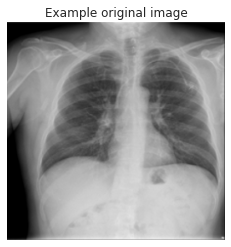

Prediction - 0.7030


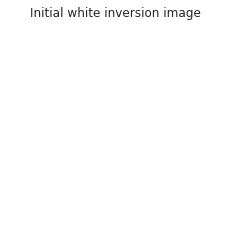

Prediction - 0.6980
Minimum over all maximum class gradient: 0.014061


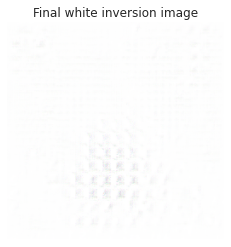

Prediction - 0.9995


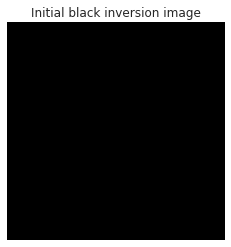

Prediction - 1.0000
Minimum over all maximum class gradient: 0.000000


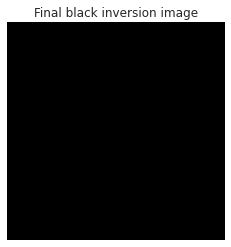

Prediction - 1.0000


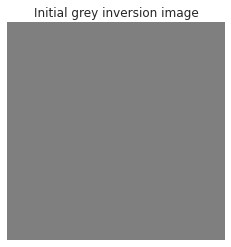

Prediction - 0.7462
Minimum over all maximum class gradient: 0.001296


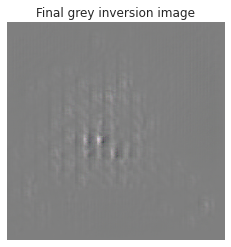

Prediction - 0.9994


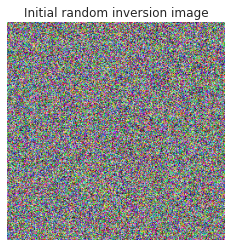

Prediction - 0.8089
Minimum over all maximum class gradient: 0.008278


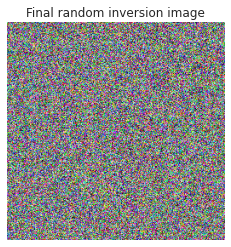

Prediction - 0.9996


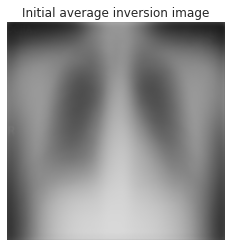

Prediction - 0.9878
Minimum over all maximum class gradient: 0.000986


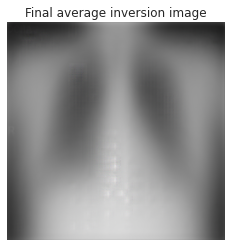

Prediction - 0.9998


In [ ]:
# example original image
plt.imshow(x_test_attack2[0])
plt.axis('off')
plt.title('Example original image')
plt.show()
print("Prediction - %.4f" % (art_classifier.predict(np.expand_dims(x_test_attack2[0], axis=0), training_mode=False)))

inits = ['white', 'black', 'grey', 'random', 'average']
for init in inits:
    average_data = None if init != 'average' else x_test_attack2
    perform_inversion(classifier=art_classifier,
                    init=init,
                    max_iter=1000,
                    lr=1.0,
                    pred_cutoff=1.0,
                    average_data=average_data)